In [12]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
# pip install textblob

   ---------------------------------------- 0.0/626.3 kB ? eta -:--:--
    --------------------------------------- 10.2/626.3 kB ? eta -:--:--
   - ------------------------------------- 30.7/626.3 kB 435.7 kB/s eta 0:00:02
   --- ----------------------------------- 61.4/626.3 kB 544.7 kB/s eta 0:00:02
   ---------- ----------------------------- 163.8/626.3 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 626.3/626.3 kB 3.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Load the DataFrame (replace with your actual data loading step)
df = pd.read_csv('./pr_sharing_visualize_output_with_patterns.csv')
df.head()

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,MergedAt,UpdatedAt,...,CSharing_URL,CSharing_Status,CSharing_DateOfConversation,CSharing_Title,CSharing_NumberOfPrompts,CSharing_TokensOfPrompts,CSharing_TokensOfAnswers,Conversation_Prompt,Conversation_Answer,Detected Patterns
0,pull request,https://github.com/labdao/plex/pull/469,AdamGoyer,labdao/plex,Go,469,add readme for openbabel to PLEX,The Chatgpt Thread used to create this pull re...,NaN,2023-07-05T03:30:59Z,...,https://chat.openai.com/share/8bd33825-e8c6-44...,200,"July 5, 2023",Open Babel on PLEX,6,2895,2311,"Good evening Chatgpt,\nI'd like your help to w...",Thanks for sharing the README file for Open Ba...,NaN
1,pull request,https://github.com/labdao/plex/pull/469,AdamGoyer,labdao/plex,Go,469,add readme for openbabel to PLEX,The Chatgpt Thread used to create this pull re...,NaN,2023-07-05T03:30:59Z,...,https://chat.openai.com/share/8bd33825-e8c6-44...,200,"July 5, 2023",Open Babel on PLEX,6,2895,2311,"Here is the PLEX readme, I think this will ans...",Thanks for sharing the README file for the PLE...,NaN
2,pull request,https://github.com/labdao/plex/pull/469,AdamGoyer,labdao/plex,Go,469,add readme for openbabel to PLEX,The Chatgpt Thread used to create this pull re...,NaN,2023-07-05T03:30:59Z,...,https://chat.openai.com/share/8bd33825-e8c6-44...,200,"July 5, 2023",Open Babel on PLEX,6,2895,2311,Essencially PLEX loads an openbabel docker con...,"Based on the given information, it looks like ...",NaN
3,pull request,https://github.com/labdao/plex/pull/469,AdamGoyer,labdao/plex,Go,469,add readme for openbabel to PLEX,The Chatgpt Thread used to create this pull re...,NaN,2023-07-05T03:30:59Z,...,https://chat.openai.com/share/8bd33825-e8c6-44...,200,"July 5, 2023",Open Babel on PLEX,6,2895,2311,"Excellent work chat, I think we should also ex...",These JSON files are indeed configuration file...,NaN
4,pull request,https://github.com/labdao/plex/pull/469,AdamGoyer,labdao/plex,Go,469,add readme for openbabel to PLEX,The Chatgpt Thread used to create this pull re...,NaN,2023-07-05T03:30:59Z,...,https://chat.openai.com/share/8bd33825-e8c6-44...,200,"July 5, 2023",Open Babel on PLEX,6,2895,2311,"Noted,\nTake a look at this docker file, and t...",This Dockerfile is used to create a Docker ima...,NaN


In [18]:
# For numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Display the correlation matrix
#print("Correlation Matrix (Numerical Columns):")
#print(correlation_matrix)

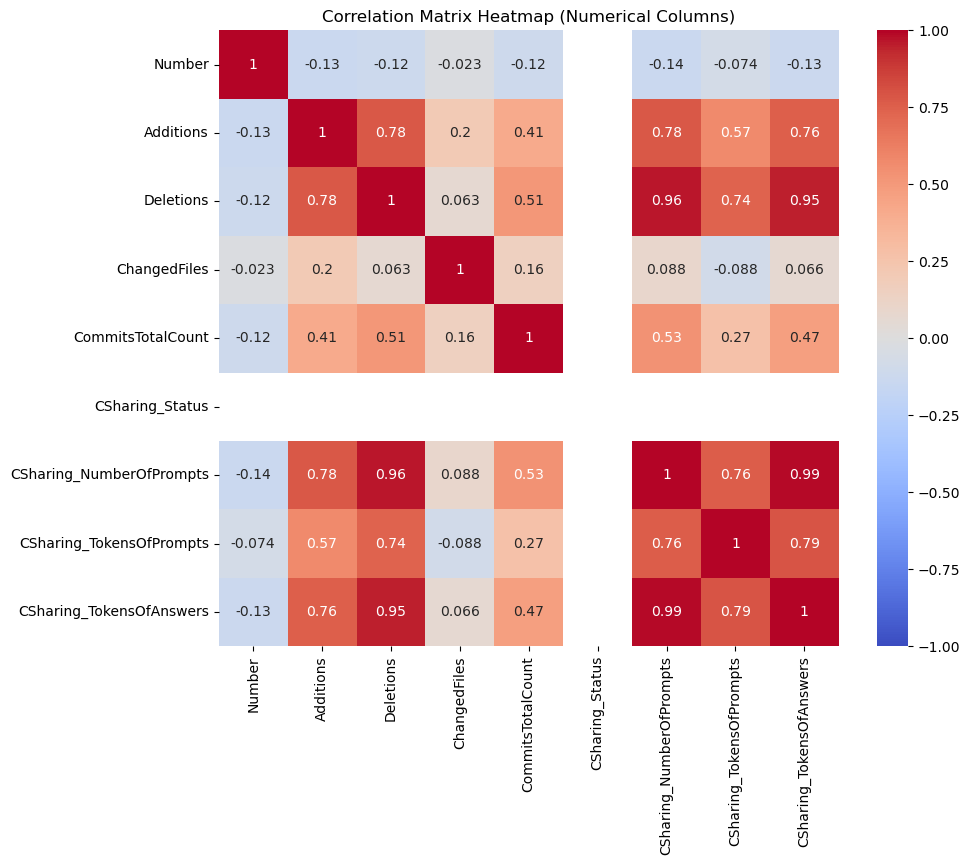

In [19]:
# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap (Numerical Columns)")
plt.show()

In [20]:
# Encode categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Calculate correlation matrix including encoded categorical columns
correlation_matrix_all = df.corr()

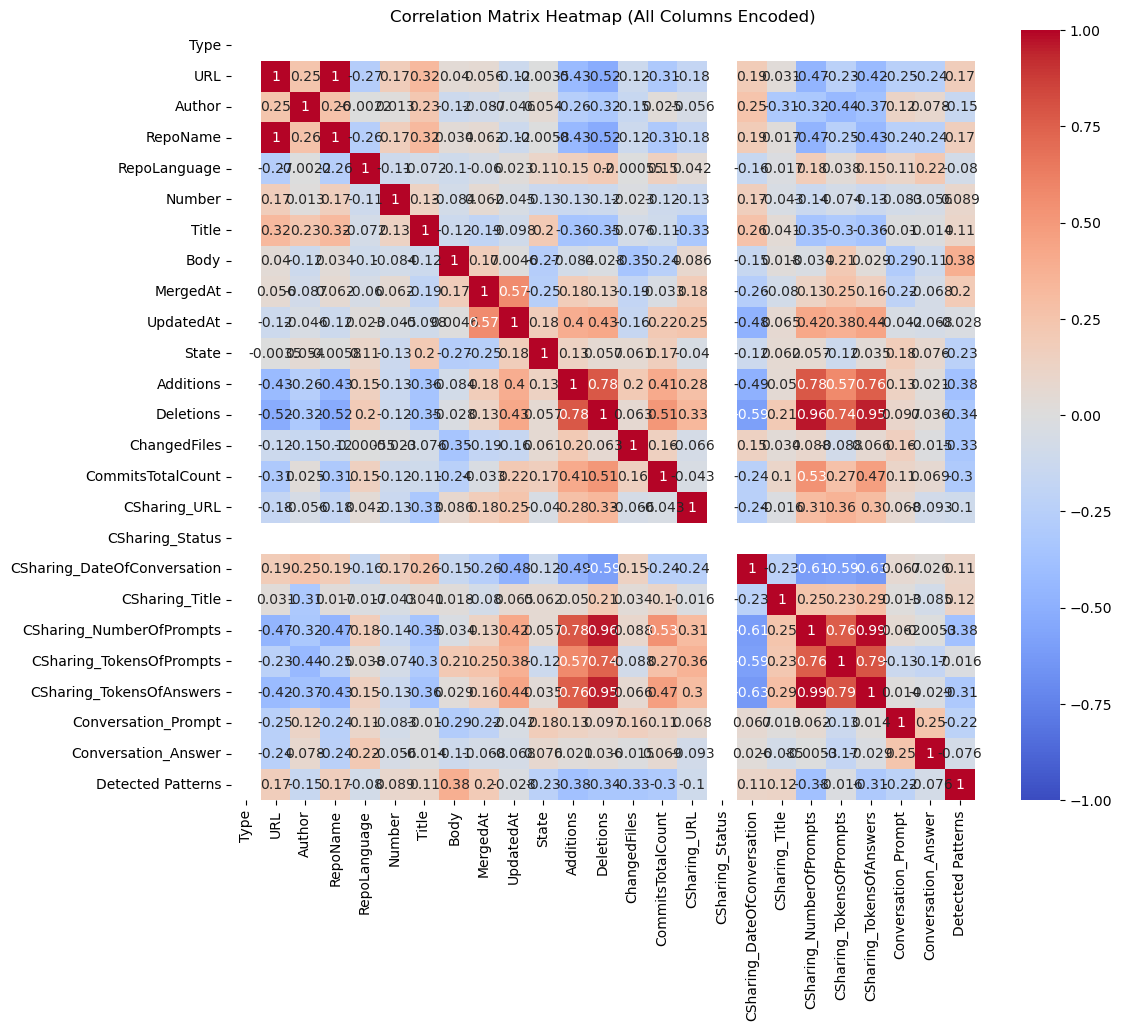

In [21]:
# Visualize the full correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap (All Columns Encoded)")
plt.show()

In [23]:
# On the basis of above correlation matrix chose columns for calculating the effectiveness of the prompt 
df['Conversation_Answer'] = df['Conversation_Answer'].astype(str)

# Define the effectiveness calculation function
def calculate_effectiveness(row):
    # Calculate response length score
    response_length_score = len(row['Conversation_Answer'].split()) if row['Conversation_Answer'] else 0
    
    # Calculate the prompt-answer token ratio
    prompt_answer_ratio = row['CSharing_TokensOfAnswers'] / (row['CSharing_TokensOfPrompts'] + 1)  # Adding 1 to avoid division by zero
    
    # Sentiment Analysis (if Conversation_Answer is non-empty)
    sentiment_score = TextBlob(row['Conversation_Answer']).sentiment.polarity if row['Conversation_Answer'] else 0

    # Weight these metrics to form a composite effectiveness score
    effectiveness_score = (0.5 * response_length_score + 0.3 * prompt_answer_ratio + 0.2 * sentiment_score)
    return effectiveness_score

# Apply the function to calculate the effectiveness score
df['Effectiveness_Score'] = df.apply(calculate_effectiveness, axis=1)

# Display the DataFrame with the new Effectiveness_Score column
print(df[['Conversation_Prompt', 'Effectiveness_Score']])

      Conversation_Prompt  Effectiveness_Score
0                     209             0.739399
1                     225             0.739399
2                     182             0.739399
3                     183             0.739399
4                     402             0.739399
...                   ...                  ...
7971                  915             1.990722
7972                  968             0.910913
7973                  224             1.979310
7974                  969             0.779009
7975                  985             2.183871

[7976 rows x 2 columns]


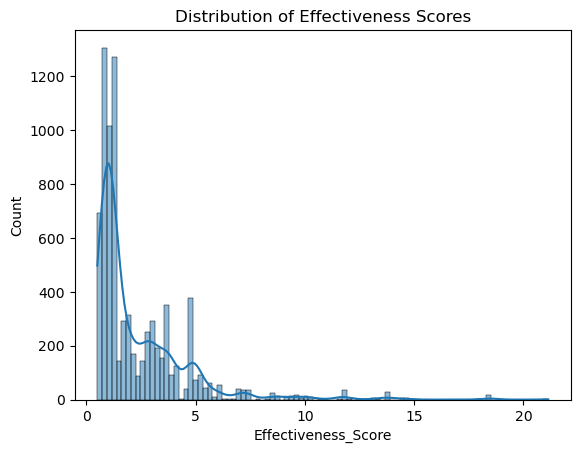

In [24]:
sns.histplot(df['Effectiveness_Score'], kde=True)
plt.title('Distribution of Effectiveness Scores')
plt.show()

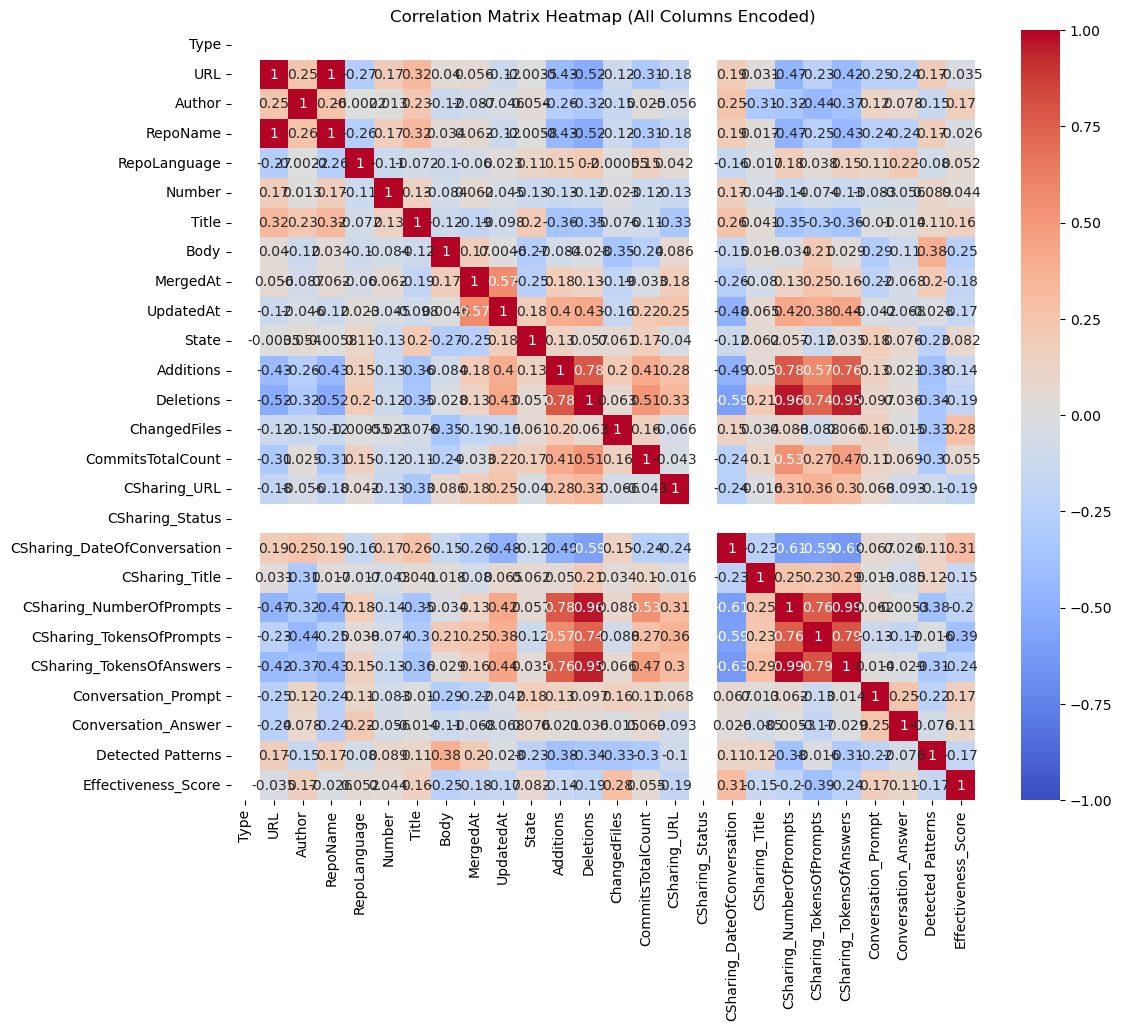

In [27]:
# Calculate correlation matrix including encoded categorical columns
correlation_matrix_all = df.corr()

# Visualize the full correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap (All Columns Encoded)")
plt.show()

In [30]:
df.head()
df.info

<bound method DataFrame.info of       Type  URL  Author  RepoName  RepoLanguage  Number  Title  Body  \
0        0  164       2       124             9     469    180   161   
1        0  164       2       124             9     469    180   161   
2        0  164       2       124             9     469    180   161   
3        0  164       2       124             9     469    180   161   
4        0  164       2       124             9     469    180   161   
...    ...  ...     ...       ...           ...     ...    ...   ...   
7971     0  202       1       150             2    1083    170    13   
7972     0   73     166        57             2     532    252    35   
7973     0   27      13        24             2     552     54    51   
7974     0   74     181        57             2     538    177    38   
7975     0   65     195        56             2    1374    250    33   

      MergedAt  UpdatedAt  ...  CSharing_Status  CSharing_DateOfConversation  \
0          194         

In [26]:
# Save the DataFrame to a CSV file
df.to_csv('pr_sharing_output_with_patterns_effectiveness_score.csv', index=False)